In [18]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib as plt


In [2]:
# Sigmoid function
def calc_sigmoid(dot_product):
    sigmoid_array = []
    for value in dot_product:
        sigmoid_value = 1 / (1 + math.exp(-value))
        sigmoid_array.append(sigmoid_value)
    return np.array(sigmoid_array)


Epoch: 9
Confusion matrix:  [[56.  8.]
 [ 6.  8.]]
82.05128205128204
Visulization of confusion matrix


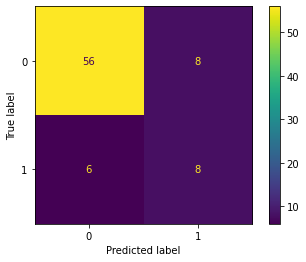

In [21]:
rawdata = pd.read_csv('diabetes (1).csv')
df = rawdata[['diabetes']].copy()
df["diabetes"].replace(["No diabetes", "Diabetes"], [0, 1], inplace=True)
dummies = pd.get_dummies(rawdata.gender)
df = pd.concat([df, dummies], axis='columns')
colsToNormalize = ["cholesterol", "glucose", "hdl_chol", "chol_hdl_ratio", "age", "height", "weight",
                   "bmi", "systolic_bp", "diastolic_bp", "waist", "hip", "waist_hip_ratio"]
for i in range(0, len(colsToNormalize)):
    df[colsToNormalize[i]] = (rawdata[colsToNormalize[i]] - rawdata[colsToNormalize[i]].mean()) / rawdata[
        colsToNormalize[i]].std(ddof=False)

df["male"] = (df["male"] - df["male"].mean()) / df["male"].std(ddof=False)
df["female"] = (df["female"] - df["female"].mean()) / df["female"].std(ddof=False)

train, test = train_test_split(df, test_size=0.2)

Y_col = 'diabetes'
X_cols = df.loc[:, df.columns != Y_col].columns
X_train, X_test, y_train, y_test = train_test_split(df[X_cols], df[Y_col], test_size=0.2)

# print(len(X_train))
# print(len(X_train.columns))
# print(len(X_test))
# print(len(X_test.columns))

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# print(len(X_train))
# print(len(X_train[0]))
# print(len(X_test))
# print(len(X_test[0]))

# Generating random initial weights for hidden layer
# Number of hidden neurons were changed for mentioned variations
op_dimensions = (10, 11)
hidden_dimensions = (10, 15)
initial_weights_hidden = np.random.uniform(-0.05, 0.05, size=hidden_dimensions)
# Generating random initial weights for output layer
initial_weights_output = np.random.uniform(-0.05, 0.05, size=op_dimensions)


# Passing the values to the perceptron
eta = 0.001
alpha = 0.1
epoch = 10
for e in range(epoch):
    training_index = 0
    previous_wt_updates_output = np.zeros(op_dimensions)
    previous_wt_updates_hidden = np.zeros(hidden_dimensions)

    # -----------------Training the network--------------------------------------

    for data in X_train:
        # Forward Phase part 1 i.e. from input to hidden layer
        h = calc_sigmoid(np.dot(data, np.transpose(initial_weights_hidden)))

        # Adding bias node input at the beginning of h
        h_with_bias = np.insert(h, 0, 1)

        # Forward Phase part 2 i.e. from hidden to input layer
        o = calc_sigmoid(np.dot(h_with_bias, np.transpose(initial_weights_output)))

        # Backward Pass part 1 i.e. computing the error
        # Getting the corresponding target
        target = y_train[training_index]
        t = []
        for i in range(0, 10):
            if i == target:
                t.append(0.9)
            else:
                t.append(0.1)

        # Checking if the output matches the target
        if np.argmax(o) == np.argmax(t):
            training_index = training_index + 1
        else:
            # Calculating delta or error for output layer
            diff = np.subtract(t, o)
            delta_o_wo_diff = np.multiply(o, np.subtract(1, o))
            delta_o = np.multiply(delta_o_wo_diff, diff)

            # Calculating delta or error for hidden layer neurons except the bias node
            # Removing the weights associated with bias node
            initial_weights_output_wo_bias = initial_weights_output[:, 1:]
            # Multiplying the weights of hidden neurons with their respective delta_o
            op_wt_delta_o_prod = np.multiply(initial_weights_output_wo_bias, delta_o[:, None])
            # Adding the product of weights and delta_o for each hidden neuron
            op_wt_delta_o_prod_sum = np.sum(op_wt_delta_o_prod, axis=0)
            # Applying delta_h formula
            delta_h_wo_sum = np.multiply(h, np.subtract(1, h))
            delta_h = np.multiply(delta_h_wo_sum, op_wt_delta_o_prod_sum)

            # Backward Pass part 2 i.e. updating the weights of output layer
            # Calculating the delta for output weights
            delta_output_weights = []
            delta_o_count = 0
            for delta_value in delta_o:
                delta_weight_part_1_wo_h = np.multiply(eta, delta_value)
                delta_weight_part_1 = np.multiply(delta_weight_part_1_wo_h, h_with_bias)
                delta_weight_part_2 = np.multiply(alpha, previous_wt_updates_output[delta_o_count])
                delta_weight = delta_weight_part_1 + delta_weight_part_2
                delta_output_weights.append(delta_weight)
                delta_o_count = delta_o_count + 1

            # Storing the delta output weights
            previous_wt_updates_output = delta_output_weights

            # Updating the output weights
            initial_weights_output = initial_weights_output + delta_output_weights

            # Backward Pass part 3 i.e. updating the weights of hidden layer
            # Calculating the delta for hidden weights
            delta_hidden_weights = []
            delta_h_count = 0
            for delta_value in delta_h:
                delta_weight_part_1_wo_data = np.multiply(eta, delta_value)
                delta_weight_part_1 = np.multiply(delta_weight_part_1_wo_data, data)
                delta_weight_part_2 = np.multiply(alpha, previous_wt_updates_hidden[delta_h_count])
                delta_weight = delta_weight_part_1 + delta_weight_part_2
                delta_hidden_weights.append(delta_weight)
                delta_h_count = delta_h_count + 1

            # Storing the delta hidden weights
            previous_wt_updates_hidden = delta_hidden_weights

            # Updating the hidden weights
            initial_weights_hidden = initial_weights_hidden + delta_hidden_weights
            training_index = training_index + 1

    # -------------------------------Testing the trained network on training samples----------------------------------

    training_index = 0
    previous_wt_updates_output = np.zeros(op_dimensions)
    previous_wt_updates_hidden = np.zeros(hidden_dimensions)
    correct_prediction = 0
    wrong_prediction = 0
    total_samples = 312
    for data in X_train:
        # Forward Phase part 1 i.e. from input to hidden layer
        h = calc_sigmoid(np.dot(data, np.transpose(initial_weights_hidden)))

        # Adding bias node input at the beginning of h
        h_with_bias = np.insert(h, 0, 1)

        # Forward Phase part 2 i.e. from hidden to input layer
        o = calc_sigmoid(np.dot(h_with_bias, np.transpose(initial_weights_output)))

        # Backward Pass part 1 i.e. computing the error
        # Getting the corresponding target
        target = y_train[training_index]
        t = []
        for i in range(0, 10):
            if i == target:
                t.append(0.9)
            else:
                t.append(0.1)

        # Checking if the output matches the target
        if np.argmax(o) == np.argmax(t):
            correct_prediction = correct_prediction + 1
            training_index = training_index + 1
        else:
            wrong_prediction = wrong_prediction + 1
            training_index = training_index + 1
    training_accuracy = (correct_prediction / total_samples) * 100
    # output_excel.write(e, 0, training_accuracy)

    # -------------------------------Testing the trained network on testing samples-----------------------------------

    testing_index = 0
    correct_prediction = 0
    wrong_prediction = 0
    previous_wt_updates_output = np.zeros(op_dimensions)
    previous_wt_updates_hidden = np.zeros(hidden_dimensions)
    total_samples = 78
    cm_dimensions = (2, 2)
    if e == 9:
        confusion_matrix = np.zeros(cm_dimensions)
    for data in X_test:
        # Forward Phase part 1 i.e. from input to hidden layer
        h = calc_sigmoid(np.dot(data, np.transpose(initial_weights_hidden)))

        # Adding bias node input at the beginning of h
        h_with_bias = np.insert(h, 0, 1)

        # Forward Phase part 2 i.e. from hidden to input layer
        o = calc_sigmoid(np.dot(h_with_bias, np.transpose(initial_weights_output)))
        # print("o: " + str(o))

        # Backward Pass part 1 i.e. computing the error
        # Getting the corresponding target
        target = y_test[testing_index]
        t = []
        for i in range(0, 10):
            if i == target:
                t.append(0.9)
            else:
                t.append(0.1)

        # Checking if the output matches the target
        predicted_value = np.argmax(o)
        actual_value = np.argmax(t)
        # print("Arg op: " + str(predicted_value))
        # print("Arg target: " + str(actual_value))
        if predicted_value == actual_value:
            # print("target matched")
            correct_prediction = correct_prediction + 1
            testing_index = testing_index + 1
            if e == 9:
                for i in range(0, 2):
                    for j in range(0, 2):
                        if i == j == actual_value:
                            confusion_matrix[i][j] = confusion_matrix[i][j] + 1
                        else:
                            continue
        else:
            wrong_prediction = wrong_prediction + 1
            testing_index = testing_index + 1
            if e == 9:
                for i in range(0, 2):
                    for j in range(0, 2):
                        if i == actual_value and j == predicted_value:
                            confusion_matrix[i][j] = confusion_matrix[i][j] + 1
                        else:
                            continue
    testing_accuracy = (correct_prediction / total_samples) * 100
    # output_excel.write(e, 1, testing_accuracy)
    if e == 9:
        print("Epoch: " + str(e))
        print("Confusion matrix:  " + str(confusion_matrix))
        print(testing_accuracy)

print("Visulization of confusion matrix")
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
display.plot()
